In [2]:
from natten import (
  NeighborhoodAttention1D,
  NeighborhoodAttention2D,
  NeighborhoodAttention3D,
)
na1d = NeighborhoodAttention1D(dim=128, kernel_size=7, dilation=3, num_heads=4)
na2d = NeighborhoodAttention2D(dim=128, kernel_size=7, dilation=3, num_heads=4)
na3d = NeighborhoodAttention3D(dim=128, kernel_size=7, dilation=3, num_heads=4)

In [3]:
na1d.extra_repr()

'head_dim=32, num_heads=4, kernel_size=7, dilation=3, has_bias=True'

In [10]:
from pathlib import Path
import pandas as pd

datapath = '/mnt/datadrive'
x = list(filter(lambda x: x.suffix=='.png', Path(datapath).rglob('*')))
df = pd.DataFrame(x, columns=['fullpath'])
df.head(5)

,fullpath
0,/mnt/datadrive/asos_dataset/tshirts_orig_biges...
1,/mnt/datadrive/asos_dataset/tshirts_orig_biges...
2,/mnt/datadrive/asos_dataset/tshirts_orig_biges...
3,/mnt/datadrive/asos_dataset/tshirts_orig_biges...
4,/mnt/datadrive/asos_dataset/tshirts_orig_biges...


In [15]:
df['item_idx'] = df['fullpath'].apply(lambda x: int(x.parent.stem))
df['item_idx'].value_counts()

item_idx
0      4
471    4
465    4
466    4
467    4
      ..
276    4
277    4
278    4
279    4
99     4
Name: count, Length: 609, dtype: int64

In [24]:
df.to_csv('all_imgs.csv', index=False)

In [23]:
from PIL import Image
from matplotlib import pyplot as plt

# for j in [0, 1, 2, 3, 44, 55, 99]:
#     for i in df[df['item_idx']==j]['fullpath'].values:
#         print(i)
#         img = Image.open(i)
#         plt.imshow(img)
#         plt.show()    

In [26]:
for group_idx, group in df.groupby(by='item_idx'):
    print(group_idx)
    print(group)
    break

0
                                            fullpath  item_idx
0  /mnt/datadrive/asos_dataset/tshirts_orig_biges...         0
1  /mnt/datadrive/asos_dataset/tshirts_orig_biges...         0
2  /mnt/datadrive/asos_dataset/tshirts_orig_biges...         0
3  /mnt/datadrive/asos_dataset/tshirts_orig_biges...         0


In [42]:
# image = Image.open(image_path).convert("RGB") 
image = Image.open('/mnt/datadrive/asos_dataset/tshirts_orig_bigest/9/2397.png').convert("RGB")
res = hp.forward_img(image).squeeze(0)

def get_clothing_agnostic(image, hp_mask, classes_to_rm=[4,6]):
    bg_color = (255,255,255)
    assert image.shape[:-1] == hp_mask.shape
    cloths_to_rm_mask = np.zeros(hp_mask.shape)
    for i in np.unique(res):
        if i in classes_to_rm:
            cloths_to_rm_mask[res==i] = 255
    image[cloths_to_rm_mask!=0] = bg_color
    return image


In [56]:
import numpy as np
# 4 === upper
# 6 === lower 

def get_clothing_agnostic(image, hp_mask, classes_to_rm=[4,6]):
    bg_color = (255,255,255)
    assert image.shape[:-1] == hp_mask.shape
    cloths_to_rm_mask = np.zeros(hp_mask.shape)
    for i in np.unique(res):
        if i in classes_to_rm:
            cloths_to_rm_mask[res==i] = 255
    image[cloths_to_rm_mask!=0] = bg_color
    return image

# xx = np.zeros(res.shape)
# for i in np.unique(res):
#     if i in [4,6]:
#         xx[res==i] = 255
# np_image = np.array(image)
# np_image[xx!=0] = (255,255,255)
# plt.imshow(np_image)
# plt.show()
print(np_image.shape[:-1])
# plt.imshow(xx)
# plt.show()

(2243, 1758)


dict_keys(['person_images', 'ca_images', 'garment_images', 'person_poses', 'garment_poses'])


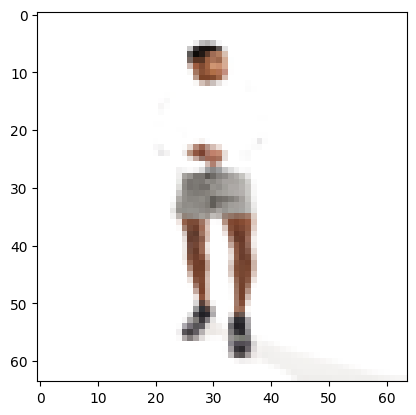

In [80]:
import torch
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import numpy as np
from clothing_segmentation import HumanParser
import pandas as pd

from torchvision import transforms as T
from matplotlib import pyplot as plt


# class SyntheticTryonDataset(Dataset):
    def __init__(self, image_size=(64,64), pose_size=(18, 2), apply_transform=True):

        self.human_parser = HumanParser()
        self.transform = T.Compose([
            # T.Resize(image_size),
            # T.CenterCrop(image_size),
            T.ToTensor(),
        ])
        self.apply_transform = apply_transform
        self.df = pd.read_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs.csv')
        self.df = self.df[self.df['pose_detected']]
        
        self.items_reverse_index = {}
        for group_idx, group in self.df.groupby(by='item_idx'):
            self.items_reverse_index[group_idx] = group['fullpath'].values        
        
        self.image_size = image_size
        # self.pose_size = pose_size
        self.openpose = MyOpenPoseDetector.from_pretrained("lllyasviel/ControlNet")

    def __len__(self):
        return len(self.items_reverse_index)
    
    def prepare_clothing_agnostic(self, img, hp_mask)-> np.array: 
        # classes_to_rm=[4,6] 
        classes_to_rm=[4]      
        # def get_clothing_agnostic(image, hp_mask, classes_to_rm=[4,6]):
        bg_color = (255,255,255)
        assert img.shape[:-1] == hp_mask.shape
        # cloths_to_rm_mask = np.zeros(hp_mask.shape)
        # for i in np.unique(res):
        #     if i in classes_to_rm:
        #         cloths_to_rm_mask[res==i] = 255
        cloths_to_rm_mask = np.isin(hp_mask, classes_to_rm)
        img[cloths_to_rm_mask!=0] = bg_color
        return img
        
    def prepare_pose(self, img):
        # pass
        pose = self.openpose(img, detect_resolution=self.image_size[0])
        return pose

    def prepare_segmented_garment(self, img, hp_mask)-> np.array:
        # classes_to_rm=[4,6] 
        classes_to_rm=[4]        
        bg_color = (255,255,255)
        assert img.shape[:-1] == hp_mask.shape
        # cloths_to_rm_mask = np.zeros(hp_mask.shape)
        # for i in np.unique(res):
        #     if i in classes_to_rm:
        #         cloths_to_rm_mask[res==i] = 255
        cloths_to_rm_mask = np.isin(hp_mask, classes_to_rm)
        img[cloths_to_rm_mask==0] = bg_color
        return img

    def __getitem__(self, idx):
        
        if idx in self.items_reverse_index:
            items_images_list = self.items_reverse_index[idx]
        else:
            items_images_list = self.items_reverse_index[idx-1]
        img_person = items_images_list[0]
        img_garment = items_images_list[1]
        
        # inputs from img1
        # noisy
        # clothing agnostic
        # person pose
        # img = img.resize((768, 768), Image.BICUBIC)
        person_image = Image.open(img_person).convert('RGB').resize((768, 768), Image.BICUBIC)
        # print(person_image.size)
        # .resize(self.image_size, Image.BICUBIC)
        np_person_image = np.array(person_image)
        person_image_resized = person_image.resize(self.image_size, Image.BICUBIC)
        person_image_hp = self.human_parser.forward_img(person_image).squeeze(0)
        
        ca_image = self.prepare_clothing_agnostic(np_person_image, person_image_hp)
        person_pose = self.prepare_pose(person_image_resized)
        
        # inputs from img2
        # garment pose
        # segmented garmend
        garment_image = Image.open(img_garment).convert('RGB').resize((768, 768), Image.BICUBIC)
        # print(garment_image.size)
        # .resize(self.image_size, Image.BICUBIC)
        np_garment_image = np.array(garment_image)
        garment_image_hp = self.human_parser.forward_img(garment_image).squeeze(0)
        
        segmented_garment = self.prepare_segmented_garment(np_garment_image, garment_image_hp) 
        garment_pose = self.prepare_pose(garment_image.resize(self.image_size, Image.BICUBIC))
        
        # person_image = torch.randn(3, *self.image_size)
        # ca_image = torch.randn(3, *self.image_size)
        # garment_image = torch.randn(3, *self.image_size)
        # person_pose = torch.randn(*self.pose_size)
        # garment_pose = torch.randn(*self.pose_size)

        # sample = {
        #     "person_images": person_image,
        #     "ca_images": ca_image,
        #     "garment_images": garment_image,
        #     "person_poses": person_pose,
        #     "garment_poses": garment_pose,
        # }

        sample = {
            "person_images": person_image_resized,
            "ca_images": Image.fromarray(ca_image.astype('uint8')).resize(self.image_size, Image.BICUBIC),
            "garment_images": Image.fromarray(segmented_garment.astype('uint8')).resize(self.image_size, Image.BICUBIC),
            "person_poses": person_pose,
            "garment_poses": garment_pose,
        }
        
        # if self.apply_transform:
        #     sample = {
        #         "person_images": self.transform(sample['person_images']),
        #         "ca_images": self.transform(sample['ca_images']),
        #         "garment_images": self.transform(sample['garment_images']),
        #         "person_poses": sample['person_poses'],
        #         "garment_poses": sample['garment_poses']
        #     }
        
        return sample
    


def tryondiffusion_collate_fn(batch):
    return {
        "person_images": torch.stack([item["person_images"] for item in batch]),
        "ca_images": torch.stack([item["ca_images"] for item in batch]),
        "garment_images": torch.stack([item["garment_images"] for item in batch]),
        "person_poses": torch.stack([item["person_poses"] for item in batch]),
        "garment_poses": torch.stack([item["garment_poses"] for item in batch]),
    }

ds = SyntheticTryonDataset()
for i in ds:
    print(i.keys())
    plt.imshow(i['ca_images'])
    plt.show()
    break

# train_dataloader = DataLoader(
#     ds,
#     batch_size=2,
#     shuffle=True,
#     collate_fn=tryondiffusion_collate_fn,
# )

# for i in train_dataloader:
#     for k,v in i.items():
#         print(k,v.shape)
#     break

In [27]:
len(ds.items_reverse_index)

609

In [11]:
import pandas as pd
df = pd.read_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs.csv')
df.head(2)

,fullpath,item_idx,pose_detected
0,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0,True
1,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0,True


In [6]:
import torch
import numpy as np
from controlnet_aux import OpenposeDetector
from controlnet_aux.open_pose import HWC3, resize_image
from diffusers.utils import load_image
import pandas as pd

df = pd.read_csv('/home/roman/parse_zara/df_clean_clean_80756.csv')

class MyOpenPoseDetector(OpenposeDetector):
    
    def __call__(self, input_image, detect_resolution=512, include_hand=False, include_face=False):
       
        if not isinstance(input_image, np.ndarray):
            input_image = np.array(input_image, dtype=np.uint8)

        input_image = HWC3(input_image)
        input_image = resize_image(input_image, detect_resolution)

        poses = self.detect_poses(input_image, include_hand, include_face)
        xy=[]
        if len(poses)>0:
            for point in poses[0].body.keypoints:
                if point is not None:
                    xy.append([point.x, point.y])
                else:
                    xy.append([0, 0])
            return np.array(xy)
        else:
            return None


from tqdm import tqdm
# Compute openpose conditioning image.
openpose = MyOpenPoseDetector.from_pretrained("lllyasviel/ControlNet")
import pickle
poses = []

left = 30000
right = 50000

for idx, i in enumerate(tqdm(df['fullpath'].values[left:right], total=len(df.iloc[left:right]))):
    try:
        image = load_image(i)
        pose = openpose(image)
    except Exception as e:
        pose = None

    if pose is None:
        poses.append(pose)
    else:
        poses.append(pickle.dumps(pose))

sliced = df.iloc[left:right]
sliced['pose_512'] = poses
sliced['pose_is_none'] = sliced['pose_512'].apply(lambda x: x is None)
sliced.to_csv(f'/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs_clean_80756_{left}-{right}.csv', index=False)

# zzz = df['fullpath'].values[2]
# image = load_image(zzz)
# pose = openpose(image)
# print(pose)

 86%|████████▌ | 17104/20000 [3:06:22<30:56,  1.56it/s]  

In [3]:
gig = df.iloc[:5725]
gig['pose_512'] = poses
gig['pose_is_none'] = gig['pose_512'].apply(lambda x: x is None)
gig.to_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs_clean_80756_5725.csv', index=False)


/tmp/ipykernel_2095431/3637896508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gig['pose_512'] = poses
/tmp/ipykernel_2095431/3637896508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gig['pose_is_none'] = gig['pose_512'].apply(lambda x: x is None)


In [37]:
array = np.array([[1, 2, 3], [4, 5, 6]])
s = np.array2string(array)
print(s)
reconstructed_array = np.fromstring(s.replace('[','').replace(']','').replace('\n',''), sep=' ')
print(reconstructed_array)

[[1 2 3]
 [4 5 6]]
[1. 2. 3. 4. 5. 6.]


In [30]:
import pickle
import numpy as np

a = np.ones(4)
# string = pickle.dumps(a)
print(string)
pickle.loads(string)

b'\x80\x04\x95\xa8\x00\x00\x00\x00\x00\x00\x00\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x04\x85\x94h\x03\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C \x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\xf0?\x94t\x94b.'


array([1., 1., 1., 1.])

In [19]:
df['pose_512']

0       [[0.505859375, 0.146875], [0.462890625, 0.2359...
1       [[0.54296875, 0.2234375], [0.55859375, 0.36406...
2                                                    None
3       [[0.328125, 0.2171875], [0.529296875, 0.285937...
4       [[0.703125, 0.1359375], [0.544921875, 0.314062...
                              ...                        
2431    [[0.47265625, 0.125], [0.525390625, 0.2203125]...
2432    [[0.380859375, 0.0], [0.234375, 0.3421875], [0...
2433    [[0.494140625, 0.0], [0.52734375, 0.1890625], ...
2434    [[0.0, 0.0], [0.56640625, 0.1609375], [0.80468...
2435    [[0.494140625, 0.0], [0.505859375, 0.1015625],...
Name: pose_512, Length: 2436, dtype: object

In [24]:
df['pose_is_none'] = df['pose_512'].apply(lambda x: x is None)

In [2]:
import pandas as pd
df = pd.read_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs.csv')

In [3]:
xxx = df[df['pose_is_none']]

In [12]:
from matplotlib import pyplot as plt

# print(len(xxx))
# for idx, (ridx, row) in enumerate(xxx.iterrows()):
#     if idx > 100:
#         print(row['fullpath'])
#         img = load_image(row['fullpath'])
#         plt.imshow(img)
#         plt.show()
#     if idx > 150:
#         break

In [20]:
np.(df.iloc[0]['pose_512'])

TypeError: a bytes-like object is required, not 'str'

In [28]:
df.iloc[0]['pose_512'].replace('\n', ',')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)

In [60]:
pose = openpose(load_image('/mnt/datadrive/asos_dataset/tshirts_orig_bigest/111/54.png'))
print(pose)

None


In [61]:
import pandas as pd

df = pd.read_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs.csv')
df.head()

,fullpath,item_idx
0,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0
1,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0
2,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0
3,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0
4,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,1


In [62]:
from tqdm import tqdm

new_boba = []
for i in tqdm(df['fullpath'].values, total=len(df)):
    res = openpose(load_image(i))
    # print(res)
    # if res is not None:
        # print(res.shape)
    new_boba.append(res is not None)
    

df['pose_detected'] = new_boba

100%|██████████| 2436/2436 [14:11<00:00,  2.86it/s]


In [69]:
df.to_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs.csv', index=False)

In [34]:
df = pd.read_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs.csv')
# items_reverse_index = {}
# df = df[df['pose_detected']]
# for group_idx, group in df.groupby(by='item_idx'):    
#     items_reverse_index[group_idx] = group['fullpath'].values

In [35]:
df

,fullpath,item_idx,pose_detected,pose_512,pose_is_none
0,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0,True,b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00...,False
1,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0,True,b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00...,False
2,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0,False,NaN,True
3,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,0,True,b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00...,False
4,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,1,True,b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00...,False
...,...,...,...,...,...
2431,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,97,True,b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00...,False
2432,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,99,True,b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00...,False
2433,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,99,True,b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00...,False
2434,/mnt/datadrive/asos_dataset/tshirts_orig_biges...,99,True,b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00...,False


In [33]:
import torch

from pathlib import Path
prepared_ds_path = Path('/mnt/datadrive/asos_dataset/prepared_64/tensors').rglob('*.pt')
for i in prepared_ds_path:
    xx = torch.load(i)
    print(xx['person_poses'])   
    break

b'\x80\x04\x95\xad\x01\x00\x00\x00\x00\x00\x00\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x12K\x02\x86\x94h\x03\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B \x01\x00\x00\x00\x00\x00\x00\x000\xe0?\xcd\xcc\xcc\xcc\xcc\xcc\xc2?\x00\x00\x00\x00\x00\xa0\xdd?333333\xce?\x00\x00\x00\x00\x00\xe0\xd7?333333\xcf?\x00\x00\x00\x00\x00\xa0\xd5?33333\xb3\xd6?\x00\x00\x00\x00\x00 \xda?\x00\x00\x00\x00\x00\x00\xd8?\x00\x00\x00\x00\x00\xa0\xe1?\xcd\xcc\xcc\xcc\xcc\xcc\xcc?\x00\x00\x00\x00\x00\xc0\xe2?\x9a\x99\x99\x99\x99\x19\xd5?\x00\x00\x00\x00\x00\x10\xe0?fffff\xe6\xd7?\x00\x00\x00\x00\x00\xe0\xda?\x9a\x99\x99\x99\x99\x19\xdd?\x00\x00\x00\x00\x00`\xdb?\x00\x00\x00\x00\x00\xc0\xe3?\x00\x00\x00\x00\x00\xe0\xdc?\x00\x00\x00\x00\x00\x80\xe9?\x00\x00\x00\x00\x00\x10\xe1?\xcd\xcc\xcc\xcc\xcc\xcc\xdc?\x00\x00\x00\x